In [168]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.spatial import ConvexHull
import cv2
from scipy.spatial.distance import cdist

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as F
from tqdm import tqdm
from IPython.display import display
from PIL import Image, ImageDraw

from scipy.interpolate import splprep, splev

### UTILITY FUNCTIONS

In [185]:
WIDTH, HEIGHT = 512, 512
BLACK = (0, 0, 255)
WHITE = (255, 255, 255)
MARGIN = 20

In [186]:
# Reads a particular csv file and returns a list of curves
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
            path_XYs.append(XYs[0])
    return path_XYs

# Plots a list of curves
def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Reads a csv file and plots the shape detailed there
def plot_shape(csv_path):
    csv_curve = read_csv(csv_path)
    plot(csv_curve)
    print("Number of curves:", len(csv_curve))
    
# Returns the corner points for a set of points
def get_corners(points, epsilon_factor=0.02):
    points = np.array(points, dtype=np.float32).reshape((-1, 1, 2))
    perimeter = cv2.arcLength(points, True)    
    # Approximate the contour with a polygon
    epsilon = epsilon_factor * perimeter
    approx = cv2.approxPolyDP(points, epsilon, True)    
    # Extract corners from the approximation
    corners = [tuple(pt[0]) for pt in approx]
    return corners

def plot_shape_and_corners(points, corners):
    points = np.array(points)
    plt.figure(figsize=(8, 6))
    plt.plot(points[:, 0], points[:, 1], 'o-', label='Original Shape')
    corners = np.array(corners)
    plt.plot(corners[:, 0], corners[:, 1], 'ro', label='Corners')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Shape and Corners')
    plt.show()

def plot_convex_hull(points):
    points = np.array(points)    
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]    
    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0], points[:, 1], color='red', s=10, label='Original Points')
    plt.plot(np.append(hull_points[:, 0], hull_points[0, 0]), np.append(hull_points[:, 1], hull_points[0, 1]), color='blue', linestyle='-', label='Convex Hull')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.title('Original Points and Convex Hull')
    plt.show()
    
def showCv2Image(img, title = "Image"):
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def checkBounds(x, y):
    if x < 0 or y < 0 :
        return False
    if x >= WIDTH or y >= HEIGHT:
        return False
    return True

### Laying out the foundation

We have multiple filters that will act on the doodle one by one to alter the array of points and the point mask (which indicates whether the subsequent filter should act on a given point or not)

In [203]:
class Filter:
    def __init__(self):
        pass
    def __call__(self, curves, pointMask, image, symmImage, bboxes):
        return curves, pointMask, image, symmImage, bboxes
    
class Mask:
    def __init__(self):
        self.data = dict()
        
    @staticmethod
    def convertKey(key):
        return tuple(list(key))
    
    def __getitem__(self, key):
        return self.data[Mask.convertKey(key)]
    
    def __setitem__(self, key, value):
        self.data[Mask.convertKey(key)] = value
        
    def __delitem__(self, key):
        del self.data[Mask.convertKey(key)]
        
    
class Doodle:
    def computeMx(self):
        allpoints = np.concatenate(self.curves, axis=0)
        self.mn_x = np.min(allpoints[:, 0])
        self.mn_y = np.min(allpoints[:, 1])
        self.mx_x = np.max(allpoints[:, 0])
        self.mx_y = np.max(allpoints[:, 1])
            
    def __init__(self, curves):
        self.curves = curves
        self.image = np.full((512, 512), 255, dtype=np.uint8)
        self.symmImage = np.full((512, 512), 255, dtype=np.uint8)
        self.bboxes = []
        self.filters = []
        self.pointMask = Mask()
        
        self.computeMx()
        scaleFactor = (WIDTH - 2 * MARGIN)/max(self.mx_x, self.mx_y)
        for i, curve in enumerate(self.curves):
            for j, point in enumerate(curve):
                self.curves[i][j] = point * [scaleFactor, scaleFactor] + [MARGIN, MARGIN]
                
        for curve in self.curves:
            for point in curve:
                self.pointMask[point] = 1
        self.computeMx()
        
    def plotCurves(self):
        image = np.full((WIDTH, HEIGHT), 255, np.uint8)
        for curve in self.curves:
            points = np.array(curve).astype(np.int32).reshape(-1, 1, 2)
            cv2.polylines(image, [points], isClosed=False, color = BLACK, thickness=2)
            
        cv2.imshow("Curves", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def addFilter(self, filter : Filter):
        self.filters.append(filter)
        return self
    
    def build(self):
        for filter in self.filters:
            self.curves, self.pointMask, self.image, self.pointMask, self.bboxes = filter(self.curves, self.pointMask, self.image, self.symmImage, self.bboxes)
        return self

### Filters to Regularize curves
Presenting the `SmoothenFilter` and the `LineFilter`

In [204]:
class SmoothenFilter(Filter):
    def __init__(self, smoothening_factor = 0.3):
        self.smoothening_factor = smoothening_factor
        
    def smoothen_curve(self, curve):
        tck, u = splprep([curve[:, 0], curve[:, 1]], s = self.smoothening_factor)
        new_points = splev(np.linspace(0, 1, len(curve) * 5), tck)
        smooth_curve = np.vstack(new_points).T
        return smooth_curve
    
    def __call__(self, curves, pointMask, image, symmImage, bboxes):
        curves = [self.smoothen_curve(curve) for curve in curves]
        return curves, pointMask, image, symmImage, bboxes

In [205]:
# This filter straightens all almost straight curves. It doesn't remove them, just straightens them
class LineFilter(Filter):
    def is_straight_line(self, curve, threshold=0.3):
        x = np.array([p[0] for p in curve]).reshape(-1, 1)
        y = np.array([p[1] for p in curve]).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        r2 = r2_score(y, y_pred)
        return r2 >= threshold
    
    def fitline(self, curve, image):
        xmax, xmin, ymax, ymin = np.argmax(curve[:, 0]), np.argmin(curve[:,0]), np.argmax(curve[:, 1]), np.argmin(curve[:,1])
        if curve[xmax, 0] - curve[xmin, 0] >= curve[ymax, 1] - curve[ymin, 1]:
            cv2.line(image, (int(curve[xmax, 0]), int(curve[xmax, 1])), (int(curve[xmin, 0]), int(curve[xmin, 1])), BLACK, 2)
        else :
            cv2.line(image, (int(curve[ymax, 0]), int(curve[ymax, 1])), (int(curve[ymin, 0]), int(curve[ymin, 1])), BLACK, 2)
        return image
        
    def __call__(self, curves, pointMask, image, symmImage, bboxes):
        newcurves = []
        for curve in curves:
            if self.is_straight_line(curve) : 
                image = self.fitline(curve, image)
            else :
                newcurves.append(curve)
            
        return newcurves, pointMask, image, symmImage, bboxes

In [206]:
# doodle = Doodle(read_csv("./problems/problems/frag0.csv"))
# doodle.plotCurves()
# doodle = doodle.addFilter(SmoothenFilter()).addFilter(LineFilter()).build()
# doodle.plotCurves()

In [151]:
class ConvexFilter(Filter):
    def is_convex_shape(self, curve, threshold=100, startToEndThresh = 50):
        curve = np.array(curve)
        # Compute the convex hull
        hull = ConvexHull(curve)
        
        # Compute the area of the original shape
        original_area = 0.5 * np.abs(np.dot(curve[:, 0], np.roll(curve[:, 1], 1)) - np.dot(curve[:, 1], np.roll(curve[:, 0], 1)))
        
        # Compute the area of the convex hull
        hull_points = curve[hull.vertices]
        hull_area = 0.5 * np.abs(np.dot(hull_points[:, 0], np.roll(hull_points[:, 1], 1)) - np.dot(hull_points[:, 1], np.roll(hull_points[:, 0], 1)))
        
        startToEnd = curve[0] - curve[-1]
        dist = np.dot(np.transpose(startToEnd), startToEnd)
        if dist > startToEndThresh * startToEndThresh : 
            return False
        
        # Difference in area
        area_difference = hull_area - original_area
        
        return area_difference <= threshold
    
    def is_ellipse_or_circle(self, curve, threshold=0.95):
        curve = np.array(curve)
    
        # Compute area using the Shoelace formula
        def polygon_area(pts):
            return 0.5 * np.abs(np.dot(pts[:, 0], np.roll(pts[:, 1], 1)) - np.dot(pts[:, 1], np.roll(pts[:, 0], 1)))
        
        # Compute perimeter
        def polygon_perimeter(pts):
            return np.sum(np.sqrt(np.sum(np.diff(np.vstack([pts, pts[0]]), axis=0)**2, axis=1)))
        
        area = polygon_area(curve)
        perimeter = polygon_perimeter(curve)
        
        # Compute circularity
        circularity = 4 * np.pi * area / (perimeter ** 2)
    
        return circularity >= threshold
    
    def is_circle(self, curve, threshold=0.8):
        # get bounding box around shape
        curve = np.array(curve)
        min_x = np.min(curve[:, 0])
        max_x = np.max(curve[:, 0])
        min_y = np.min(curve[:, 1])
        max_y = np.max(curve[:, 1])

        # find aspect ratio of bounding box
        width = max_x - min_x
        height = max_y - min_y
        if height < width :
            width, height = height, width
        aspect_ratio = width / height

        return aspect_ratio >= threshold
    
    def fit_circle(self, curve, image, symmImage):
        def get_circle(circle_list):
            # calculate circle center using mean
            x, y = zip(*circle_list)
            x_center = np.mean(x)
            y_center = np.mean(y)

            # rearrange points such that origin becomes center
            u = x - x_center
            v = y - y_center

            # get radius by solving least mean squared error 
            distances = np.sqrt(u**2 + v**2)
            radius = np.mean(distances)

            # print(x_center, y_center, radius)
            return int(x_center), int(y_center), int(radius)
        
        x_center, y_center, radius = get_circle(curve)
        cv2.circle(image, (x_center, y_center), radius, BLACK, 2)
        cv2.circle(symmImage, (x_center, y_center), radius, BLACK, 2)
        return image, symmImage
    
    def fit_ellipse(self, curve, image, symmImage):
        # Convert the list of points to a numpy array
        curve = np.array(curve, dtype=np.float32)
        
        # Fit an ellipse to the points
        ellipse = cv2.fitEllipse(curve)
        
        # Extract ellipse parameters
        center, axes, angle = ellipse
        major_axis, minor_axis = axes
        
        # Create points along the ellipse
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_points = np.array([
            center[0] + major_axis / 2 * np.cos(theta) * np.cos(np.radians(angle)) - minor_axis / 2 * np.sin(theta) * np.sin(np.radians(angle)),
            center[1] + major_axis / 2 * np.cos(theta) * np.sin(np.radians(angle)) + minor_axis / 2 * np.sin(theta) * np.cos(np.radians(angle))
        ]).T

        cv2.polylines(image, [ellipse_points.reshape(-1, 1, 2)], isClosed=True, color = BLACK, thickness=2)
        cv2.polylines(symmImage, [ellipse_points.reshape(-1, 1, 2)], isClosed=True, color = BLACK, thickness=2)

        return image, symmImage
    
    def fit_rectangle(self, curve, image, symmImage):
        # Convert the list of points to a numpy array
        curve = np.array(curve, dtype=np.float32)
        
        # Fit a rotated rectangle to the points
        rect = cv2.minAreaRect(curve)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        top_left = tuple(box[0])
        bottom_right = tuple(box[2])

        cv2.rectangle(image, top_left, bottom_right, color=BLACK, thickness=2)
        cv2.rectangle(symmImage, top_left, bottom_right, color=BLACK, thickness=2)
        
        return image, symmImage
    
    def fit_polygon(self, curve, image, symmImage):
        # Get corners of the approximated polygon
        corners = get_corners(curve)
        points = np.array(curve)
        corners = np.array(corners)

        # Calculate centroid of corners
        centroid = np.mean(corners, axis=0)

        # Find the point with the highest y-value to fix its position
        fixed_point = corners[np.argmax(corners[:, 1])]
        
        # Calculate radius from centroid to the fixed point
        radius = np.linalg.norm(fixed_point - centroid)
        
        # Calculate initial angle of the fixed point from the centroid
        initial_angle = np.arctan2(fixed_point[1] - centroid[1], fixed_point[0] - centroid[0])
        
        # Number of vertices
        num_vertices = len(corners)
        
        # Generate the regular polygon
        regular_polygon = []
        
            
        for i in range(num_vertices):
            angle = initial_angle + 2 * np.pi * i / num_vertices
            x = centroid[0] + radius * np.cos(angle)
            y = centroid[1] + radius * np.sin(angle)
            if not checkBounds(x, y):
                continue
            regular_polygon.append((x, y))
        
        regular_polygon = np.array(regular_polygon).astype(np.int32).reshape(-1, 1, 2)
        cv2.polylines(image, [regular_polygon], isClosed=True, color = BLACK, thickness=2)
        cv2.polylines(symmImage, [regular_polygon], isClosed=True, color = BLACK, thickness=2)
        
        return image, symmImage
    
    def __call__(self, curves, pointMask, image, symmImage, bboxes):
        newcurves = []
        for curve in curves:
            if self.is_convex_shape(curve):
                if self.is_ellipse_or_circle(curve):
                    if self.is_circle(curve):
                        image, symmImage = self.fit_circle(curve, image, symmImage) 
                    else :
                        image, symmImage = self.fit_ellipse(curve, image, symmImage)
                else :
                    image, symmImage = self.fit_polygon(curve, image, symmImage)
            else :
                newcurves.append(curve)
                
        return newcurves, pointMask, image, symmImage, bboxes

### Multi-stroke curve detection and completion
We shall specify the `PixelDetector` which uses `FasterRCNN` to detect shapes and then complete them using `ShapeFilter`.

In [152]:

label_map = {
    "circle" : 1, "octagon" : 2, "hexagon" : 3, "star" : 4, "square" : 5, "triangle" : 6, "line" : 7
}
inverseLabelMap = {}
for (key, value) in label_map.items():
    inverseLabelMap[value] = key

In [207]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def initDetector():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    num_classes = 8
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model = model.to(device)
    return model

def transform(img):
    img = F.pil_to_tensor(img)
    retimg = img / 255.0
    return retimg

class PixelDetector(Filter):
    def load_model(self, name, backup = initDetector, frommem = True):
        model = backup()
        if frommem == False:
            print("Initializing from scratch.")
            return model
        try : 
            model.load_state_dict(torch.load(f"{name}", map_location=torch.device('cpu')))
            print("Loaded model successfully.")
        except:
            print("Couldn't find model. Initializing from scratch.")
        return model
    
    def __init__(self, modelpath):
        self.model = self.load_model(modelpath)
        self.model.eval()
        
    @staticmethod
    def convertToImage(curves):
        image = np.full((WIDTH, HEIGHT), 255, np.uint8)
        for curve in curves:
            points = np.array(curve).astype(np.int32).reshape(-1, 1, 2)
            cv2.polylines(image, [points], isClosed=False, color = BLACK, thickness=2)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        return image
    
    def __call__(self, curves, pointMask, image, symmImage, bboxes):
        residualImage = PixelDetector.convertToImage(curves)
        output = self.model([transform(residualImage).to(device)])[0]
        bboxes = [(bounds.cpu().detach().numpy(), label.cpu().detach().numpy(), score.cpu().detach().numpy()) for (bounds, label, score) in zip(output["boxes"], output["labels"], output["scores"]) if score >= 0.9]        
        return curves, pointMask, image, symmImage, bboxes

In [212]:
doodle = Doodle(read_csv("./problems/problems/isolated.csv"))
# doodle.plotCurves()
doodle = doodle.addFilter(SmoothenFilter())
doodle = doodle.addFilter(LineFilter())
doodle = doodle.addFilter(ConvexFilter())
doodle = doodle.addFilter(PixelDetector("ShapeDetector_pixels\models\detector_v1.pth")).build()
# showCv2Image(doodle.image)

c:\Users\subha\miniconda3\envs\vision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\subha\miniconda3\envs\vision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model successfully.


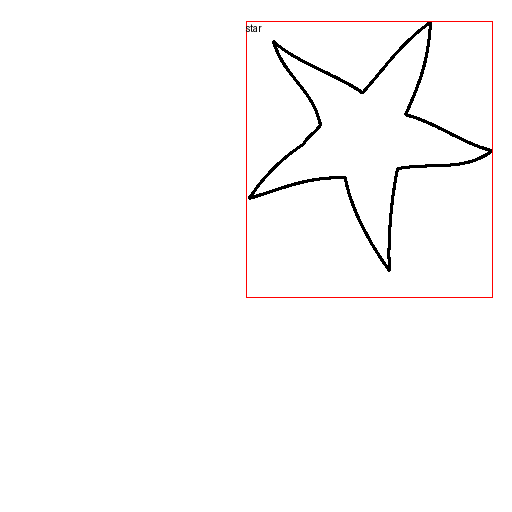

In [213]:
image = PixelDetector.convertToImage(doodle.curves)
draw = ImageDraw.Draw(image)
for bbox in doodle.bboxes:
    draw.rectangle(bbox[0], outline = "red")
    draw.text((bbox[0][0], bbox[0][1]), inverseLabelMap[int(bbox[1])],(0, 0, 0))
display(image)